In [58]:
# Step 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
import plotly.graph_objects as go
from prophet import Prophet

In [2]:
df = pd.read_csv('clean_data.csv')

In [3]:
df.head(5)

Unnamed: 0  Store  Dept        Date  Weekly_Sales  IsHoliday  Temperature  \
0           0      1     1  2010-02-05      24924.50      False        42.31   
1           1      1     2  2010-02-05      50605.27      False        42.31   
2           2      1     3  2010-02-05      13740.12      False        42.31   
3           3      1     4  2010-02-05      39954.04      False        42.31   
4           4      1     5  2010-02-05      32229.38      False        42.31   

   Fuel_Price  MarkDown1  MarkDown2  ...  Unemployment  Type    Size  \
0       2.572        0.0        0.0  ...         8.106     A  151315   
1       2.572        0.0        0.0  ...         8.106     A  151315   
2       2.572        0.0        0.0  ...         8.106     A  151315   
3       2.572        0.0        0.0  ...         8.106     A  151315   
4       2.572        0.0        0.0  ...         8.106     A  151315   

   Super_Bowl  Labor_Day Thanksgiving  Christmas  week  month  year  
0       False      False        False      False     5      2  2010  
1       False      False        False      False     5      2  2010  
2       False      False        False      False     5      2  2010  
3       False      False        False      False     5      2  2010  
4       False      False        False      False     5      2  2010  

[5 rows x 24 columns]

In [4]:
df.drop(columns=['Unnamed: 0'], inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

## Plotting Sales

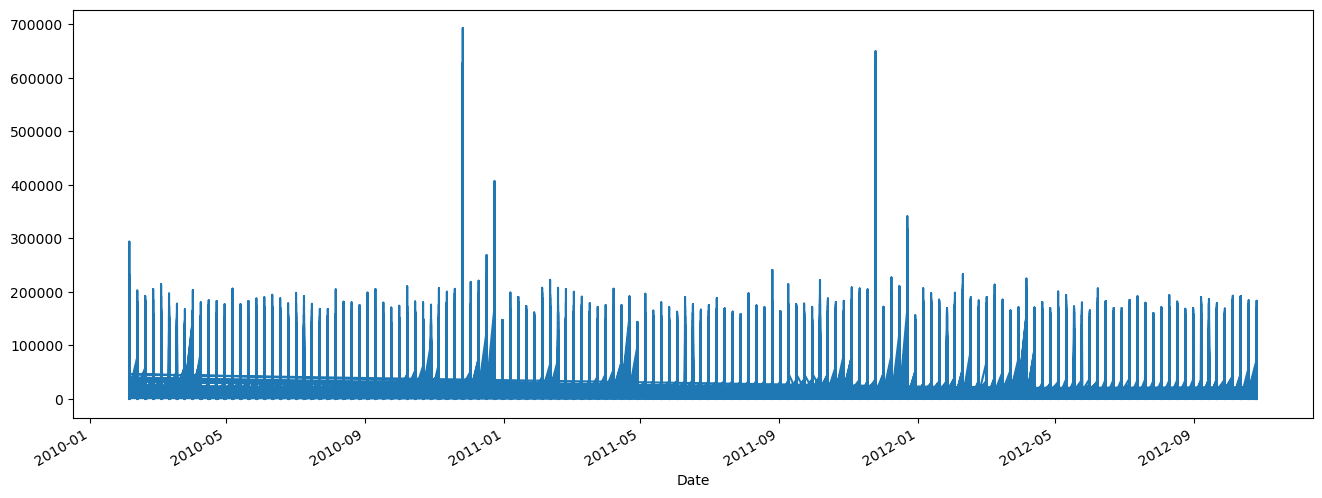

In [5]:
plt.figure(figsize=(16,6))
df['Weekly_Sales'].plot()
plt.show()

In [73]:
df_numeric = df.select_dtypes(include='number')
df_week = df_numeric.resample('D').mean()
df_month = df_numeric.resample('MS').mean()

In [74]:
# Step 3: Load and Join IsHoliday data
holiday_df = pd.read_csv('test.csv')
holiday_df['Date'] = pd.to_datetime(holiday_df['Date'])
holiday_df.set_index('Date', inplace=True)
holiday_week = holiday_df.resample('D').first()
holiday_week = holiday_week.rename(columns={'IsHoliday': 'IsHoliday_Flag'})
df_week_with_holiday = df_week.join(holiday_week['IsHoliday_Flag'])

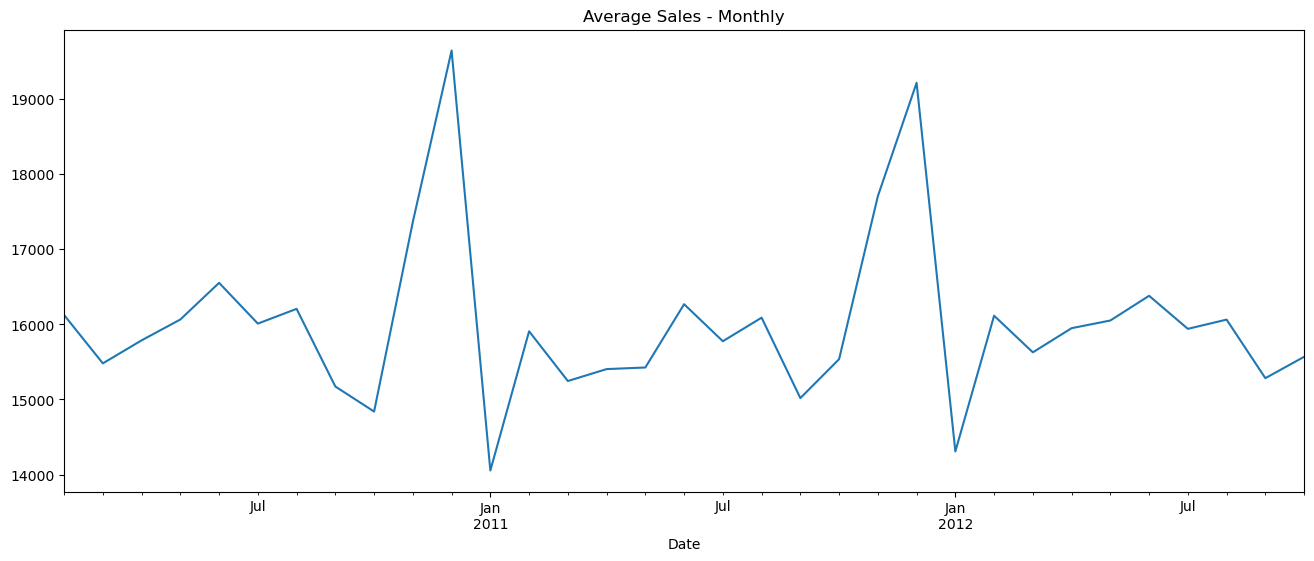

In [75]:
plt.figure(figsize=(16,6))
df_month['Weekly_Sales'].plot()
plt.title('Average Sales - Monthly')
plt.show()

Data is non-stationary. So, I will try to find more stationary version on it.

### To Observe 4 and 12-weeks Rolling Mean and Std

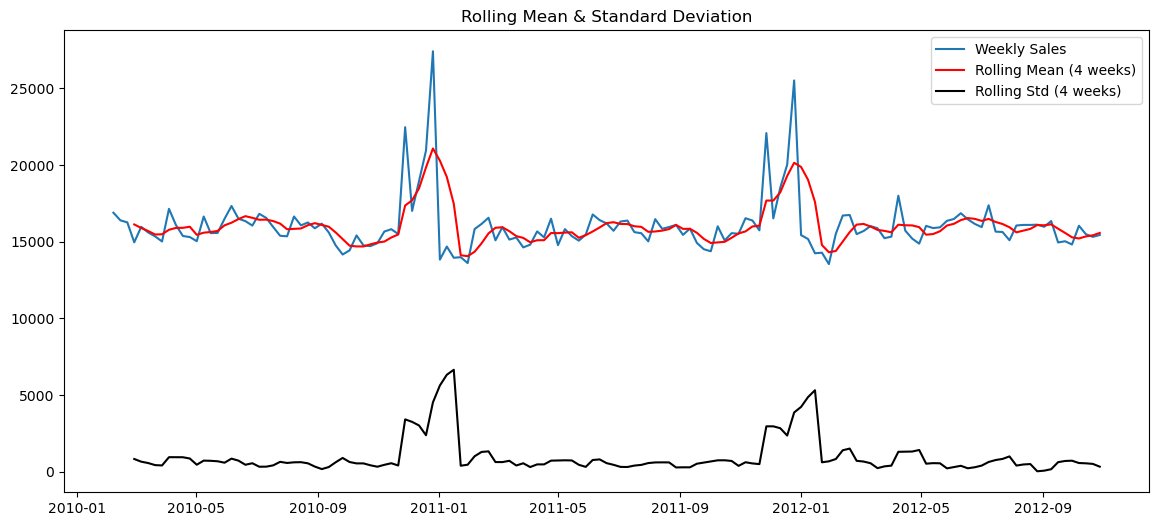

In [9]:
# Step 4: Rolling Mean & STD Plot
roll_mean = df_week['Weekly_Sales'].rolling(window=4).mean()
roll_std = df_week['Weekly_Sales'].rolling(window=4).std()

plt.figure(figsize=(14, 6))
plt.plot(df_week['Weekly_Sales'], label='Weekly Sales')
plt.plot(roll_mean, color='red', label='Rolling Mean (4 weeks)')
plt.plot(roll_std, color='black', label='Rolling Std (4 weeks)')
plt.title('Rolling Mean & Standard Deviation')
plt.legend()
plt.show()

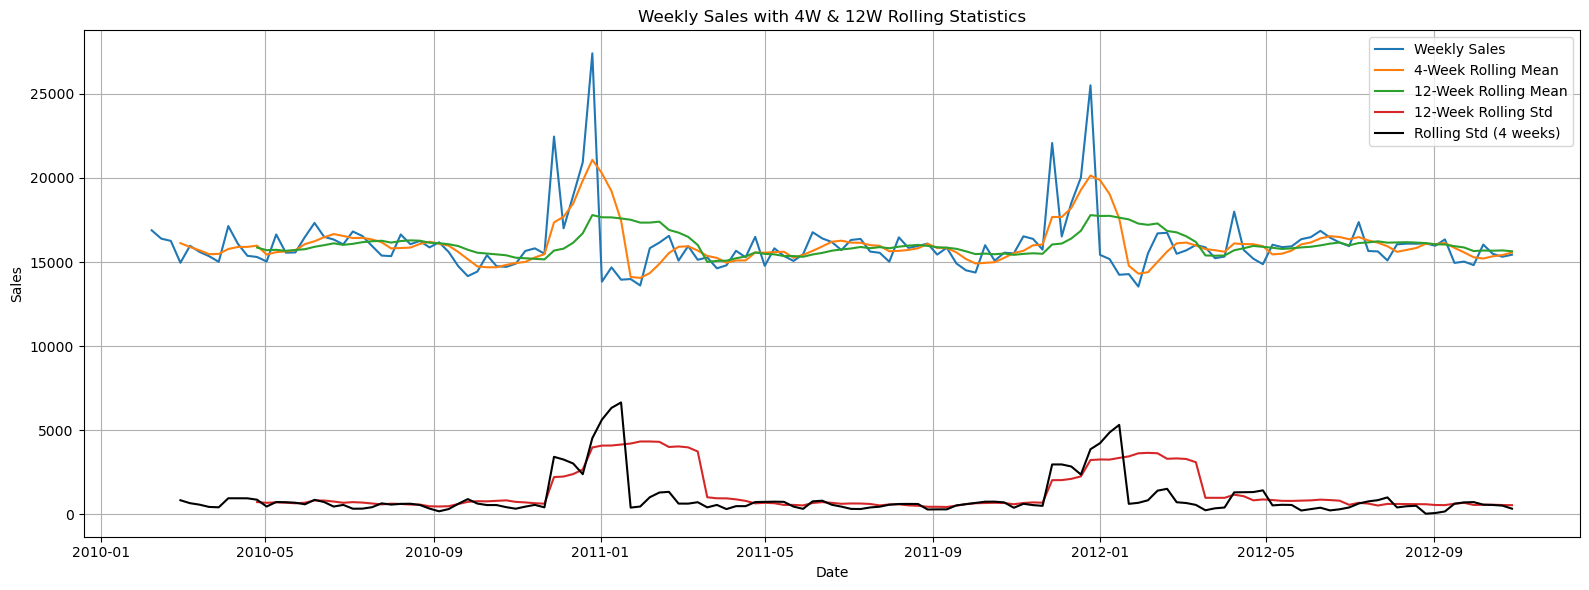

In [10]:
roll_mean_4w = df_week['Weekly_Sales'].rolling(window=4).mean()
roll_mean_12w = df_week['Weekly_Sales'].rolling(window=12).mean()
roll_std_12w = df_week['Weekly_Sales'].rolling(window=12).std()

# Plot
plt.figure(figsize=(16, 6))
plt.plot(df_week['Weekly_Sales'], label='Weekly Sales')
plt.plot(roll_mean_4w, label='4-Week Rolling Mean')
plt.plot(roll_mean_12w, label='12-Week Rolling Mean')
plt.plot(roll_std_12w, label='12-Week Rolling Std')
plt.plot(roll_std, color='black', label='Rolling Std (4 weeks)')
plt.title("Weekly Sales with 4W & 12W Rolling Statistics")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

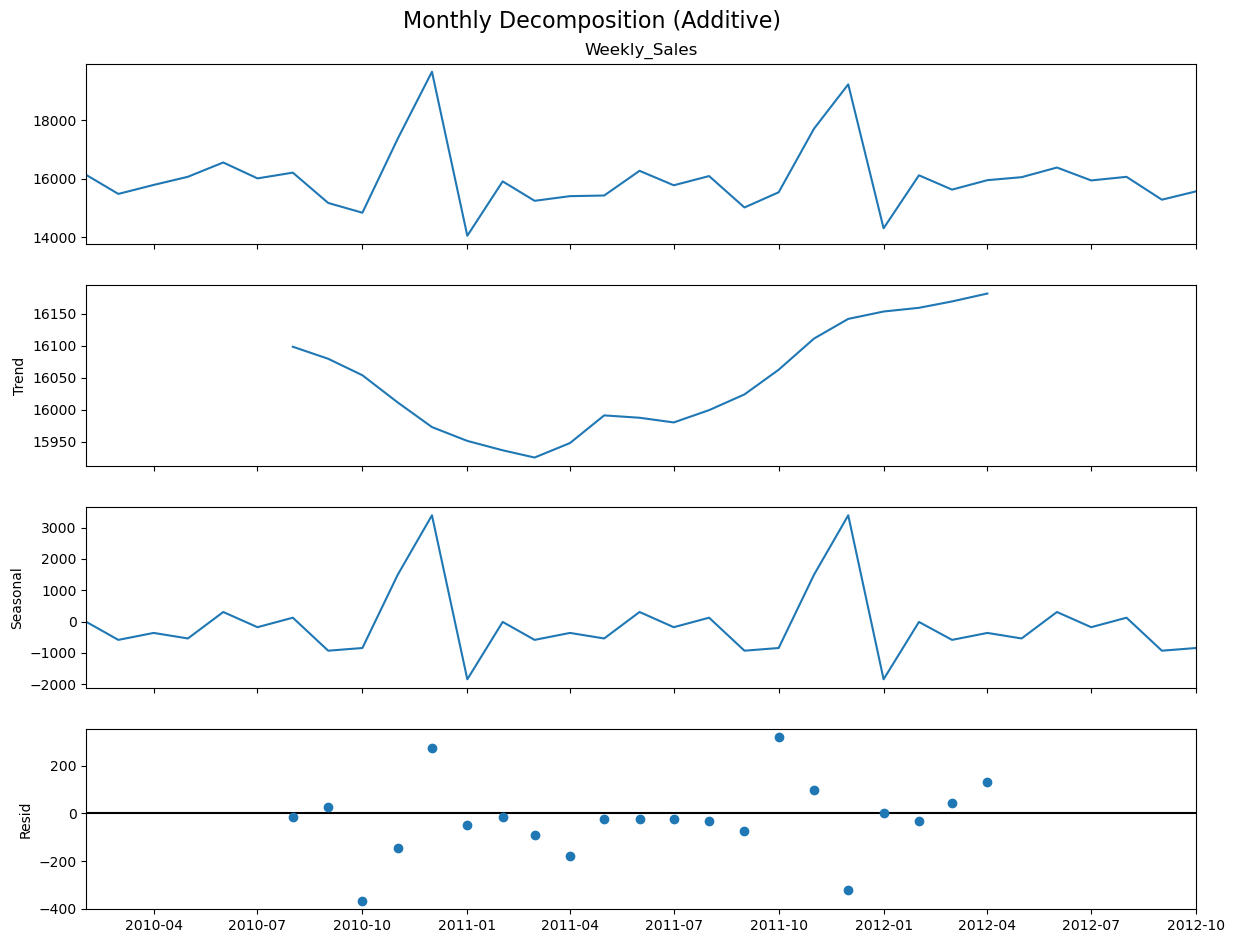

In [11]:
# Step 5: Monthly Decomposition
decomposition = seasonal_decompose(df_month['Weekly_Sales'], model='additive', period=12)
fig = decomposition.plot()
fig.set_size_inches(14, 10)
plt.suptitle("Monthly Decomposition (Additive)", fontsize=16)
plt.show()

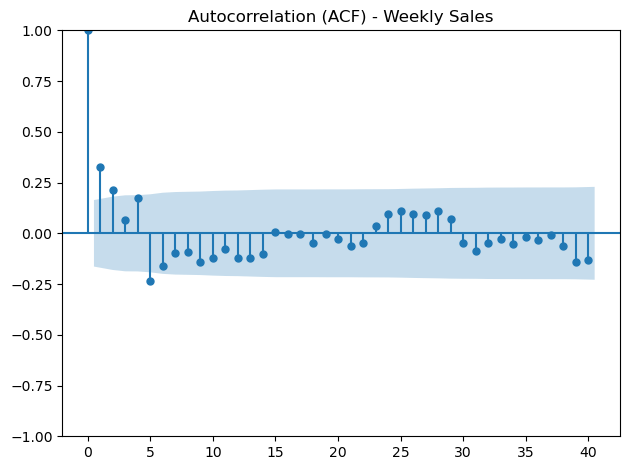

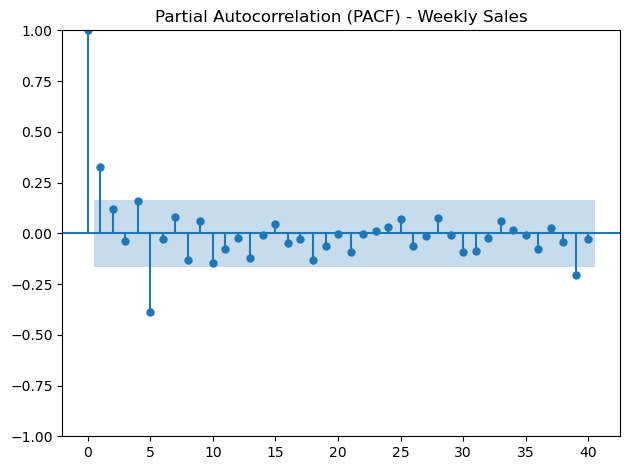

In [12]:
sales_series = df_week['Weekly_Sales'].dropna()

# ACF plot
plot_acf(sales_series, lags=40)
plt.title("Autocorrelation (ACF) - Weekly Sales")
plt.tight_layout()
plt.show()

# PACF plot
plot_pacf(sales_series, lags=40, method='ywm')  # more stable method
plt.title("Partial Autocorrelation (PACF) - Weekly Sales")
plt.tight_layout()
plt.show()

### Adfuller Test - Stationary check

In [13]:
adfuller(df_week['Weekly_Sales'])

(-5.927107223737576,
 2.429049208204163e-07,
 4,
 138,
 {'1%': -3.47864788917503,
  '5%': -2.882721765644168,
  '10%': -2.578065326612056},
 2261.596421168073)

From test and observations, data is not stationary. So, will try to find more stationary version of it.

In [26]:
train_data = df_week[:int(0.7*(len(df_week)))] 
test_data = df_week[int(0.7*(len(df_week))):]

print('Train:', train_data.shape)
print('Test:', test_data.shape)

Train: (100, 16)
Test: (43, 16)


In [27]:
target = "Weekly_Sales"
used_cols = [c for c in df_week.columns.to_list() if c not in [target]] # all columns except price

# assigning train-test X-y values

X_train = train_data[used_cols]
X_test = test_data[used_cols]
y_train = train_data[target]
y_test = test_data[target]

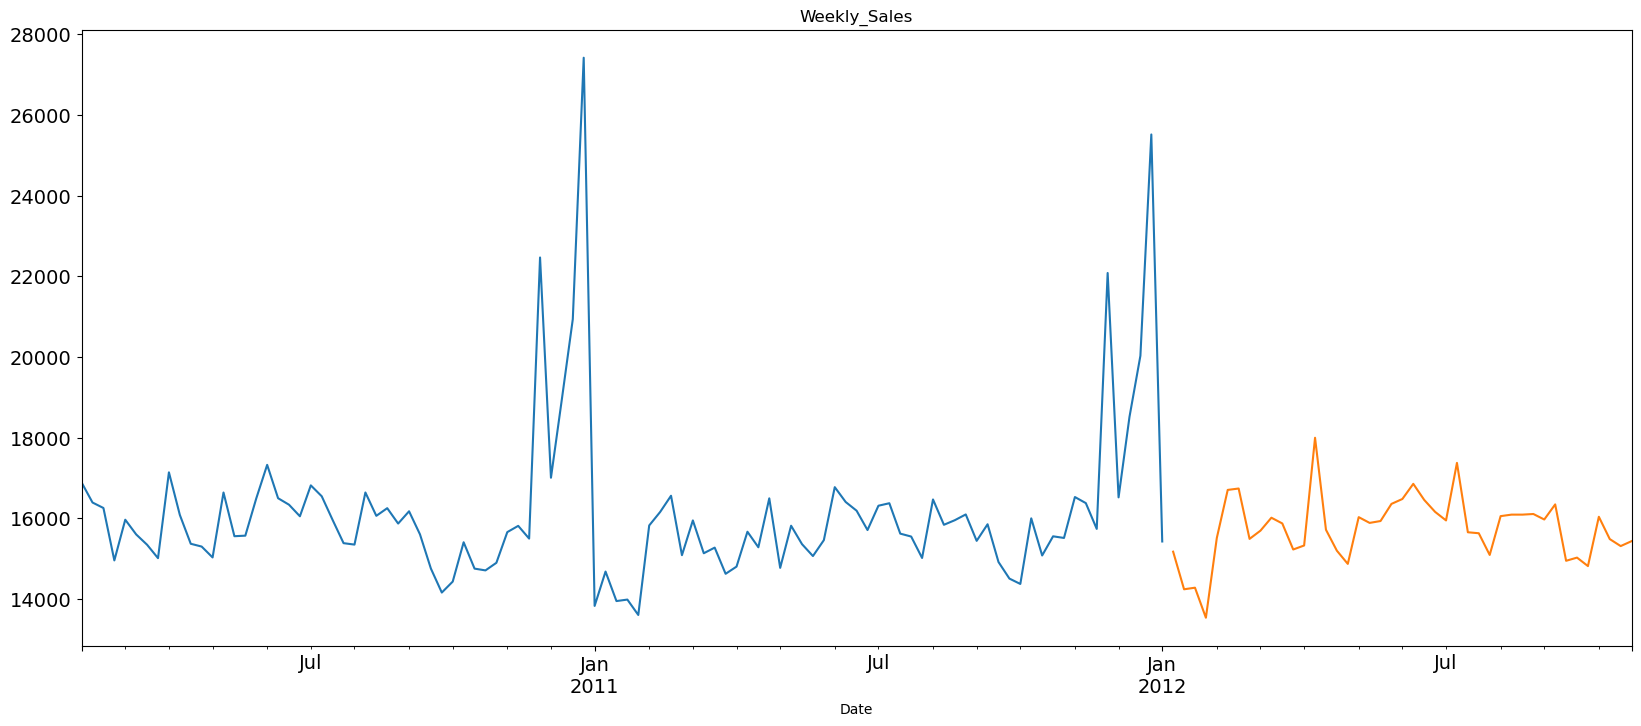

In [28]:
train_data['Weekly_Sales'].plot(figsize=(20,8), title= 'Weekly_Sales', fontsize=14)
test_data['Weekly_Sales'].plot(figsize=(20,8), title= 'Weekly_Sales', fontsize=14)
plt.show()

### Decomposing Weekly Data to Observe Seasonality

In [71]:
decomposition = seasonal_decompose(df_week['Weekly_Sales'], model='additive', period=20)

<Figure size 2000x2400 with 0 Axes>

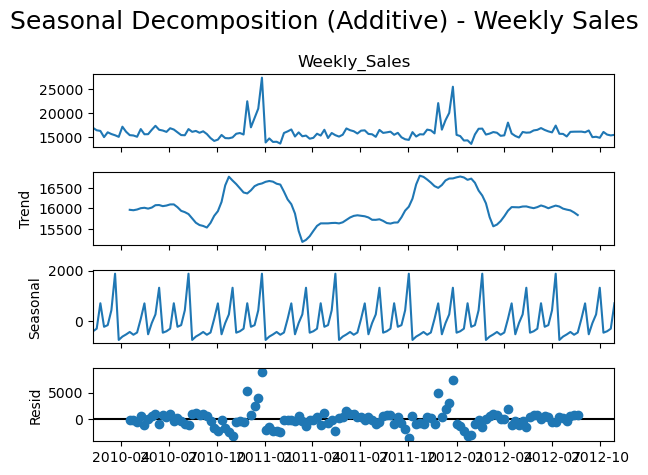

In [72]:
# Plot decomposition
plt.figure(figsize=(20, 24))
decomposition.plot()
plt.suptitle("Seasonal Decomposition (Additive) - Weekly Sales", fontsize=18)
plt.tight_layout()
plt.show()

From the graphs above, every 20 step seasonality converges to beginning point. This helps me to tune model.

### Making Data Stationary

#### 1. First-Order Differencing

In [20]:
df_week_diff = df_week['Weekly_Sales'].diff().dropna()

In [21]:
diff_roll_mean = df_week_diff.rolling(window=4, center=False).mean()
diff_roll_std = df_week_diff.rolling(window=4, center=False).std()

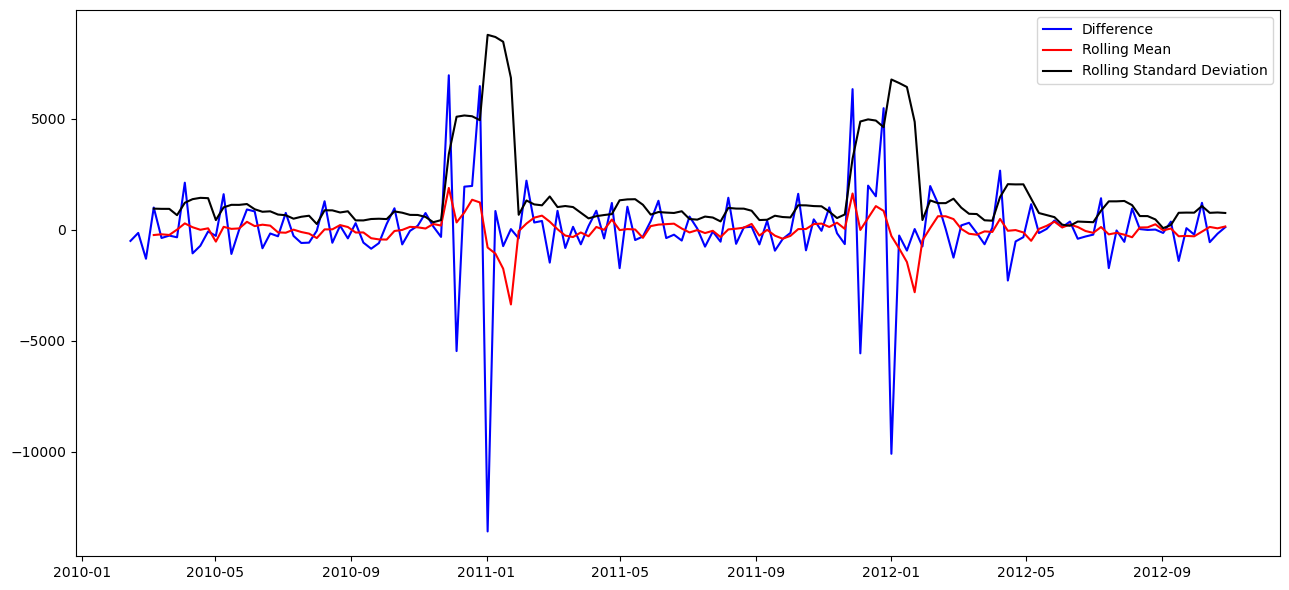

In [22]:
fig, ax = plt.subplots(figsize=(13, 6))
ax.plot(df_week_diff, color='blue',label='Difference')
ax.plot(diff_roll_mean, color='red', label='Rolling Mean')
ax.plot(diff_roll_std, color='black', label='Rolling Standard Deviation')
ax.legend()
fig.tight_layout()

#### 2. Lagged Shift

In [23]:
df_week_lag = df_week['Weekly_Sales'].shift().dropna()

In [24]:
lag_roll_mean = df_week_lag.rolling(window=4, center=False).mean() 
lag_roll_std = df_week_lag.rolling(window=4, center=False).std()

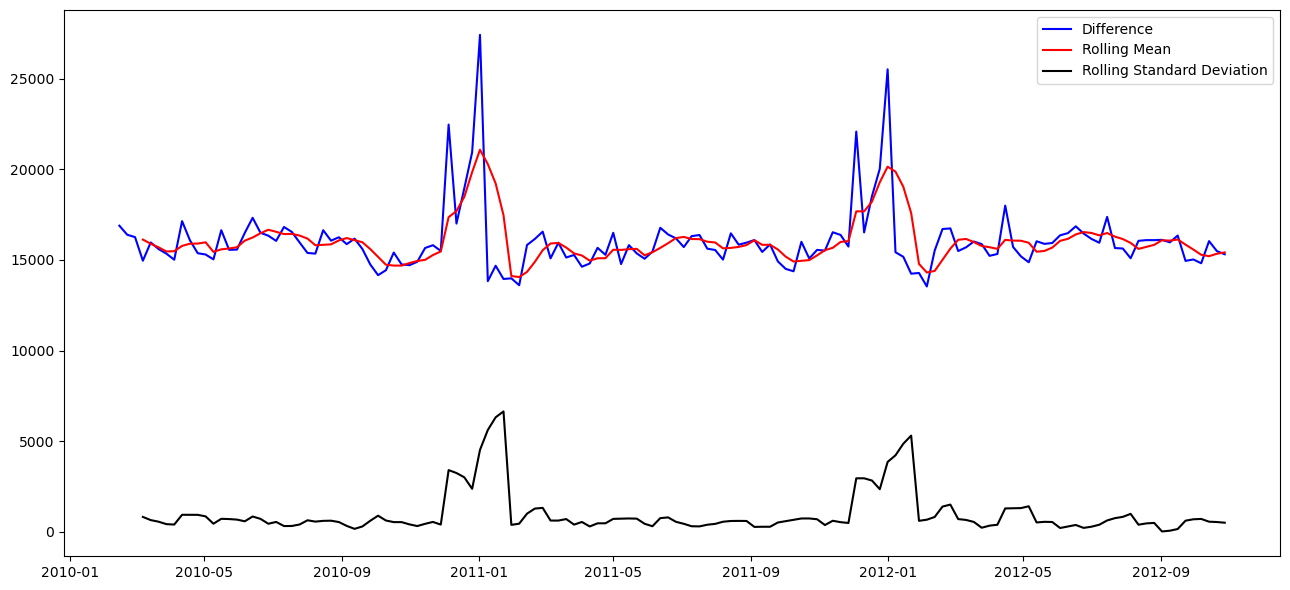

In [25]:
fig, ax = plt.subplots(figsize=(13, 6))
ax.plot(df_week_lag, color='blue',label='Difference')
ax.plot(lag_roll_mean, color='red', label='Rolling Mean')
ax.plot(lag_roll_std, color='black', label='Rolling Standard Deviation')
ax.legend()
fig.tight_layout()

#### 3. Log Transformation

In [26]:
logged_sales = np.log1p(df_week['Weekly_Sales'])

In [27]:
log_roll_mean = logged_sales.rolling(window=2, center=False).mean()
log_roll_std = logged_sales.rolling(window=2, center=False).std()

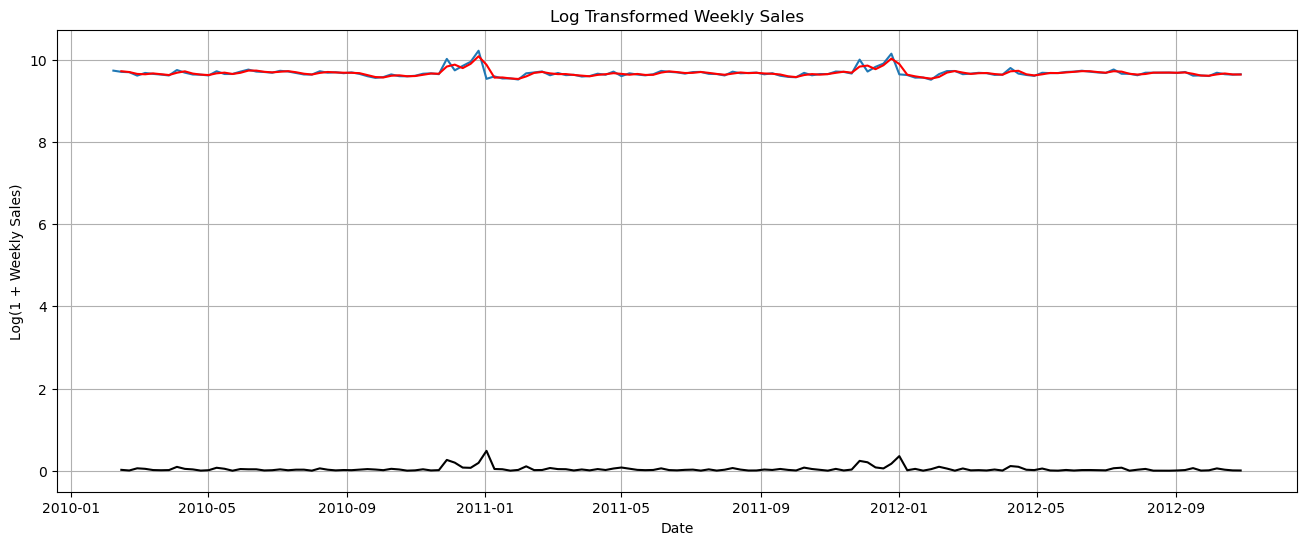

In [28]:
# Plot log-transformed sales
plt.figure(figsize=(16,6))
plt.plot(logged_sales)
plt.plot(log_roll_mean, color='red', label='Rolling Mean')
plt.plot(log_roll_std, color='black', label='Rolling Standard Deviation')
plt.title("Log Transformed Weekly Sales")
plt.xlabel("Date")
plt.ylabel("Log(1 + Weekly Sales)")
plt.grid(True)
plt.show()

In [29]:
print(type(df_week))

<class 'pandas.core.frame.DataFrame'>


## Auto-ARIMA MODEL

In [30]:
# Step 7: Train/Test Split
train_data_diff = df_week_diff[:int(0.7*(len(df_week_diff)))]
test_data_diff = df_week_diff[int(0.7*(len(df_week_diff))):]

In [31]:
print('Train:', train_data_diff.shape)
print('Test:', test_data_diff.shape)

Train: (99,)
Test: (43,)


In [84]:
# Step 8: Auto ARIMA Model
model_auto_arima = auto_arima(train_data_diff, trace=True,start_p=0, start_q=0, start_P=0, start_Q=0,
                  max_p=20, max_q=20, max_P=20, max_Q=20, seasonal=True,maxiter=200,
                  information_criterion='aic',stepwise=False, suppress_warnings=True, D=1, max_D=10,
                  error_action='ignore',approximation = False)
model_auto_arima.fit(train_data_diff)

 ARIMA(0,0,0)(0,0,0)[1] intercept   : AIC=1826.858, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[1] intercept   : AIC=1793.619, Time=0.05 sec
 ARIMA(0,0,2)(0,0,0)[1] intercept   : AIC=1795.532, Time=0.21 sec
 ARIMA(0,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,0,4)(0,0,0)[1] intercept   : AIC=inf, Time=0.36 sec
 ARIMA(0,0,5)(0,0,0)[1] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(1,0,0)(0,0,0)[1] intercept   : AIC=1804.051, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,0,2)(0,0,0)[1] intercept   : AIC=1794.966, Time=0.11 sec
 ARIMA(1,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(1,0,4)(0,0,0)[1] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(2,0,0)(0,0,0)[1] intercept   : AIC=1801.215, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(2,0,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(2,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.45 sec
 ARIMA(3,0,0)(0,0,0)[1] intercept   : AIC=1791.045, Tim

ARIMA(maxiter=200, order=(3, 0, 2), scoring_args={},
      seasonal_order=(0, 0, 0, 1), suppress_warnings=True)

In [86]:
print(model_auto_arima.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   99
Model:               SARIMAX(3, 0, 2)   Log Likelihood                -884.461
Date:                Tue, 08 Apr 2025   AIC                           1782.922
Time:                        23:10:27   BIC                           1801.088
Sample:                    02-14-2010   HQIC                          1790.272
                         - 01-01-2012                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     91.2166    477.652      0.191      0.849    -844.964    1027.397
ar.L1         -1.3324      0.109    -12.231      0.000      -1.546      -1.119
ar.L2         -1.1692      0.138     -8.482      0.0

In [89]:
import joblib
joblib.dump(model_auto_arima, 'auto_arima_model.pkl')

['auto_arima_model.pkl']

In [91]:
y_pred = model_auto_arima.predict(n_periods=len(test_data_diff))
y_pred = pd.DataFrame(y_pred,index = test_data_diff.index,columns=['Prediction'])

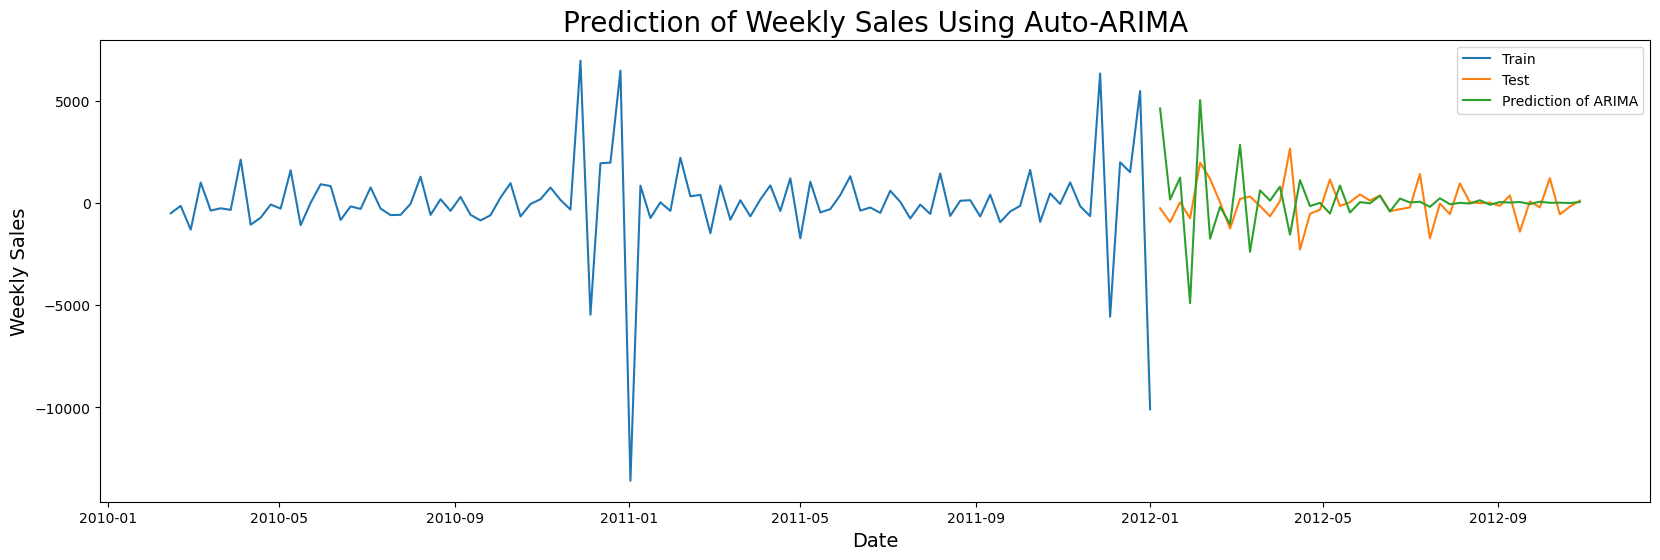

In [92]:
plt.figure(figsize=(20,6))
plt.title('Prediction of Weekly Sales Using Auto-ARIMA', fontsize=20)
plt.plot(train_data_diff, label='Train')
plt.plot(test_data_diff, label='Test')
plt.plot(y_pred, label='Prediction of ARIMA')
plt.legend(loc='best')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Weekly Sales', fontsize=14)
plt.show()

In [97]:
forecast = model_auto_arima.predict(n_periods=len(test_data_diff))
forecast = pd.Series(forecast, index=test_data_diff.index)

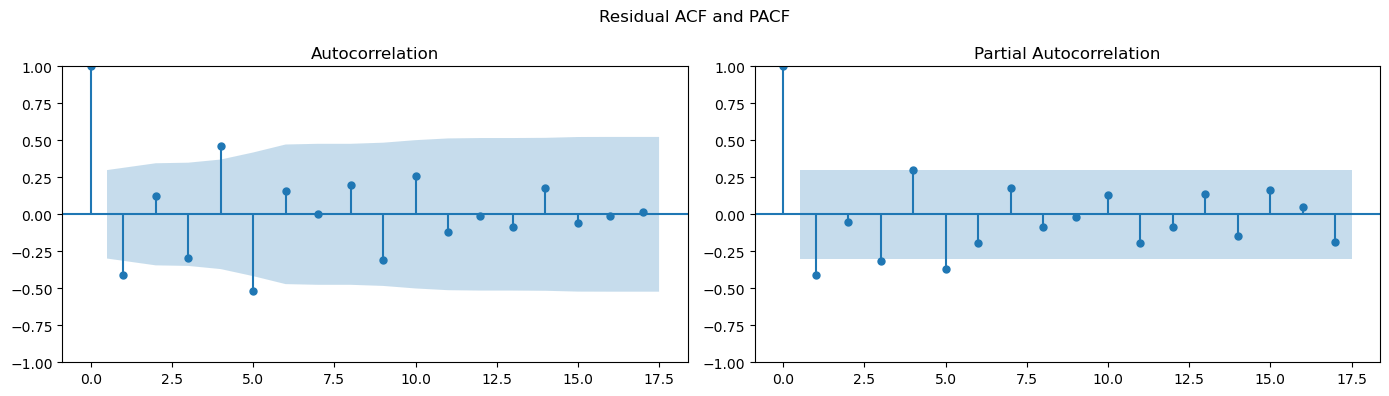

In [98]:
# Step 11: Residual Diagnostics
residuals = test_data_diff - forecast
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
plot_acf(residuals, ax=axes[0])
plot_pacf(residuals, ax=axes[1])
plt.suptitle("Residual ACF and PACF")
plt.tight_layout()
plt.show()

In [102]:
# Step 14: WMAE Metric
is_holiday_test = df_week_with_holiday.loc[test.index, "IsHoliday_Flag"]

# Define WMAE function
def wmae(true, pred, is_holiday):
    weights = is_holiday.apply(lambda x: 5 if x else 1)
    return np.sum(weights * np.abs(true - pred)) / np.sum(weights)

# Compute WMAE
wmae_score = wmae(test_orig, pred_orig.loc[test.index], is_holiday_test)

print("WMAE:", wmae_score)

WMAE: 15747.430208247748


In [106]:
# Step 15: Output Evaluation
mae = mean_absolute_error(test_orig, pred_orig.loc[test.index])
rmse = np.sqrt(mean_squared_error(test_orig, pred_orig.loc[test.index]))

# Already computed earlier
wmae_score = wmae(test_orig, pred_orig.loc[test.index], is_holiday_test)
lb_pvalue = lb_test['lb_pvalue'].values[0]  # Assumes you have Ljung-Box test result

# Print evaluation metrics
print("📊 Model Evaluation Metrics:")
print(f"MAE  : {mae:.2f}")
print(f"RMSE : {rmse:.2f}")
print(f"WMAE : {wmae_score:.2f}")
print(f"🔍 Ljung-Box Test p-value: {lb_pvalue:.8f}")

📊 Model Evaluation Metrics:
MAE  : 15747.43
RMSE : 15767.90
WMAE : 15747.43
🔍 Ljung-Box Test p-value: 0.00000034


In [36]:
def wmae(true, pred, is_holiday):
    weights = is_holiday.apply(lambda x: 5 if x else 1)  # Weight holidays 5 times higher
    return np.sum(weights * np.abs(true - pred)) / np.sum(weights)

In [35]:
def calculate_accuracy(true, pred, tolerance=0.05):
    # Calculate the percentage error between true and predicted values
    percentage_error = np.abs(true - pred) / true
    accuracy = np.mean(percentage_error <= tolerance) * 100  # Accuracy as percentage
    return accuracy

In [37]:
def evaluate_metrics(true, pred, residuals, is_holiday):
    # Mean Absolute Error (MAE)
    mae = mean_absolute_error(true, pred)
    
    # Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mean_squared_error(true, pred))
    
    # Weighted Mean Absolute Error (WMAE)
    wmae_score = wmae(true, pred, is_holiday)
    
    # Ljung-Box Test on residuals for autocorrelation
    lb_test = acorr_ljungbox(residuals, lags=10, return_df=True)
    lb_pvalue = lb_test['lb_pvalue'].values[0]  # p-value of Ljung-Box test
    
    # Calculate Accuracy
    accuracy = calculate_accuracy(true, pred, tolerance=0.05)  # Accuracy with ±5% tolerance
    
    return mae, rmse, wmae_score, lb_pvalue, accuracy

In [38]:
def plot_predictions(train_data, test_data, y_pred, title='Model Forecast vs Actual Sales'):
    fig = go.Figure()

    # Plot Train Data (Sales data up to the training period)
    fig.add_trace(go.Scatter(x=train_data.index, y=train_data['Weekly_Sales'], mode='lines', name='Train Data', line=dict(color='blue', width=2)))
    
    # Plot Test Data (Actual Sales)
    fig.add_trace(go.Scatter(x=test_data.index, y=test_data['Weekly_Sales'], mode='lines', name='Test Data', line=dict(color='orange', width=2)))
    
    # Plot Predictions (ARIMA/XGBoost/Prophet Forecast)
    fig.add_trace(go.Scatter(x=test_data.index, y=y_pred, mode='lines', name='Model Prediction', line=dict(color='green', width=2, dash='dash')))
    
    # Update layout for better aesthetics
    fig.update_layout(
        title=title,
        xaxis_title='Date',
        yaxis_title='Weekly Sales',
        template='plotly',  # Use plotly's default template for white background
        plot_bgcolor='white',  # Set the plot background to white
        paper_bgcolor='white',  # Set the overall background to white
        legend=dict(x=0.01, y=0.99, font=dict(size=12)),
        xaxis=dict(tickangle=45),  # Rotate x-axis labels to avoid overlap
        yaxis=dict(tickformat=".2f"),  # Show y-axis with two decimal places for clarity
    )
    
    fig.show()

In [40]:
df_week['Log_Weekly_Sales'] = np.log1p(df_week['Weekly_Sales'])

In [41]:
df_week_diff = df_week.copy()
df_week_diff['Weekly_Sales'] = df_week['Weekly_Sales'].diff().dropna()

In [42]:
df_week_diff = df_week_diff.dropna()

In [43]:
train_data_diff = df_week_diff[:int(0.7*(len(df_week_diff)))]
test_data_diff = df_week_diff[int(0.7*(len(df_week_diff))):]

In [44]:
print(f"Train: {train_data_diff.shape}")
print(f"Test: {test_data_diff.shape}")

Train: (99, 17)
Test: (43, 17)


In [45]:
is_holiday_test = df_week_with_holiday.loc[test_data_diff.index, "IsHoliday_Flag"]

## Auto ARIMA

In [46]:
model_auto_arima = auto_arima(train_data_diff['Weekly_Sales'], trace=True, start_p=0, start_q=0, start_P=0, start_Q=0,
                              max_p=20, max_q=20, max_P=20, max_Q=20, seasonal=True, maxiter=200,
                              information_criterion='aic', stepwise=False, suppress_warnings=True, D=1, max_D=10,
                              error_action='ignore', approximation=False)
model_auto_arima.fit(train_data_diff['Weekly_Sales'])

 ARIMA(0,0,0)(0,0,0)[1] intercept   : AIC=1826.858, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[1] intercept   : AIC=1793.619, Time=0.07 sec
 ARIMA(0,0,2)(0,0,0)[1] intercept   : AIC=1795.532, Time=0.19 sec
 ARIMA(0,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,0,4)(0,0,0)[1] intercept   : AIC=inf, Time=0.31 sec
 ARIMA(0,0,5)(0,0,0)[1] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(1,0,0)(0,0,0)[1] intercept   : AIC=1804.051, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,0,2)(0,0,0)[1] intercept   : AIC=1794.966, Time=0.10 sec
 ARIMA(1,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(1,0,4)(0,0,0)[1] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(2,0,0)(0,0,0)[1] intercept   : AIC=1801.215, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(2,0,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(2,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.45 sec
 ARIMA(3,0,0)(0,0,0)[1] intercept   : AIC=1791.045, Tim

ARIMA(maxiter=200, order=(3, 0, 2), scoring_args={},
      seasonal_order=(0, 0, 0, 1), suppress_warnings=True)

In [47]:
y_pred_arima = model_auto_arima.predict(n_periods=len(test_data_diff))
y_pred_arima = pd.Series(y_pred_arima, index=test_data_diff.index)

In [48]:
residuals_arima = test_data_diff['Weekly_Sales'] - y_pred_arima

In [49]:
mae_arima, rmse_arima, wmae_arima, lb_pvalue_arima, accuracy_arima = evaluate_metrics(test_data_diff['Weekly_Sales'], y_pred_arima, residuals_arima, is_holiday_test)

In [50]:
print("📊 ARIMA Model Evaluation Metrics:")
print(f"MAE  : {mae_arima:.2f}")
print(f"RMSE : {rmse_arima:.2f}")
print(f"WMAE : {wmae_arima:.2f}")
print(f"Ljung-Box Test p-value: {lb_pvalue_arima:.8f}")
print(f"Accuracy: {accuracy_arima:.2f}%")

📊 ARIMA Model Evaluation Metrics:
MAE  : 1103.68
RMSE : 1681.42
WMAE : 1103.68
Ljung-Box Test p-value: 0.00564873
Accuracy: 53.49%


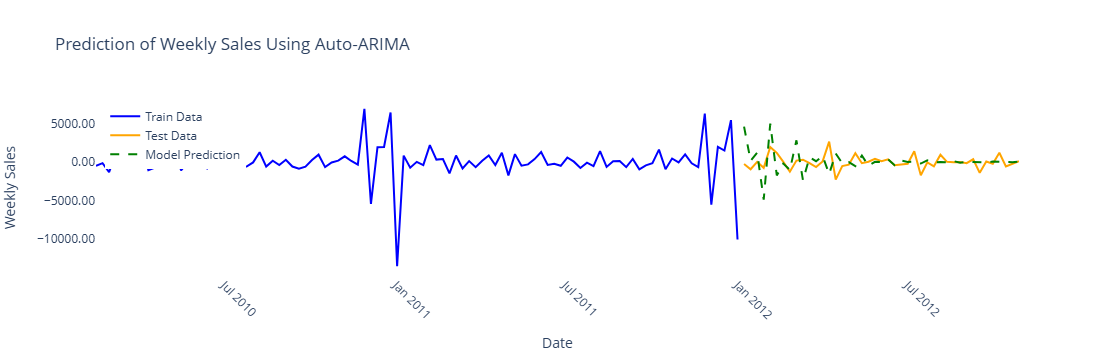

In [51]:
plot_predictions(train_data_diff, test_data_diff, y_pred_arima, title="Prediction of Weekly Sales Using Auto-ARIMA")

## XGBoost Model

In [53]:
df_week_diff['Lag_1'] = df_week_diff['Weekly_Sales'].shift(1)
df_week_diff['Lag_2'] = df_week_diff['Weekly_Sales'].shift(2)
df_week_diff['Lag_3'] = df_week_diff['Weekly_Sales'].shift(3)

In [54]:
# Step 2: Create Rolling Features (Rolling Mean and Rolling Standard Deviation)
df_week_diff['Rolling_Mean'] = df_week_diff['Weekly_Sales'].rolling(window=4).mean()
df_week_diff['Rolling_Std'] = df_week_diff['Weekly_Sales'].rolling(window=4).std()

# Drop NaN values created by lag and rolling calculations
df_week_diff = df_week_diff.dropna()

In [55]:
# Step 3: Train-Test Split (70% Train, 30% Test)
train_data_diff = df_week_diff[:int(0.7*(len(df_week_diff)))]
test_data_diff = df_week_diff[int(0.7*(len(df_week_diff))):]

print(f"Train: {train_data_diff.shape}")
print(f"Test: {test_data_diff.shape}")

Train: (97, 22)
Test: (42, 22)


In [56]:
X_train_xgb = train_data_diff[['Lag_1', 'Lag_2', 'Lag_3', 'Rolling_Mean', 'Rolling_Std']]
X_test_xgb = test_data_diff[['Lag_1', 'Lag_2', 'Lag_3', 'Rolling_Mean', 'Rolling_Std']]
y_train_xgb = train_data_diff['Weekly_Sales']
y_test_xgb = test_data_diff['Weekly_Sales']

In [59]:
xgb_model = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.05, max_depth=6, subsample=0.7, colsample_bytree=0.7)
xgb_model.fit(X_train_xgb, y_train_xgb)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [60]:
y_pred_xgb = xgb_model.predict(X_test_xgb)

In [61]:
residuals_xgb = y_test_xgb - y_pred_xgb

# Evaluate XGBoost Model
mae_xgb, rmse_xgb, wmae_xgb, lb_pvalue_xgb, accuracy_xgb = evaluate_metrics(y_test_xgb, y_pred_xgb, residuals_xgb, is_holiday_test)

In [62]:
print(f"XGBoost Model Evaluation Metrics:")
print(f"MAE: {mae_xgb:.2f}")
print(f"RMSE: {rmse_xgb:.2f}")
print(f"WMAE: {wmae_xgb:.2f}")
print(f"Ljung-Box Test p-value: {lb_pvalue_xgb:.8f}")
print(f"Accuracy: {accuracy_xgb:.2f}%")

XGBoost Model Evaluation Metrics:
MAE: 443.50
RMSE: 635.06
WMAE: 433.19
Ljung-Box Test p-value: 0.43628203
Accuracy: 50.00%


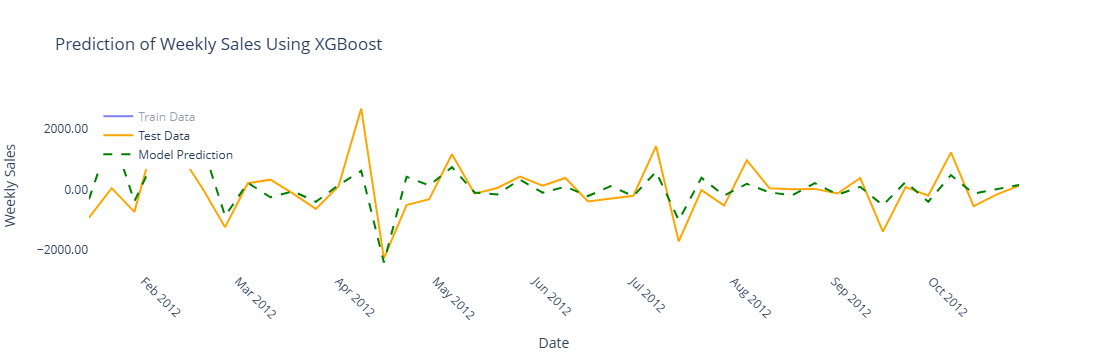

In [64]:
plot_predictions(train_data_diff, test_data_diff, y_pred_xgb, title="Prediction of Weekly Sales Using XGBoost")